In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem

ModuleNotFoundError: No module named 'matplotlib'

Here we load the datasets with all the computed properties 

In [2]:
choriso = pd.read_csv("../data/processed/cjhif_small_properties.csv", sep="\t").fillna(0)
uspto = pd.read_csv("../data/processed/uspto_properties.csv", sep="\t").fillna(0)

## Plot rxn supertypes in ChORISO and USPTO

In [3]:
def count_level_i(v, i=1):
    lvl_freq = (
        v.astype(str).apply(lambda x: ".".join(x.split(".")[:i])).rename("one").value_counts()
    )
    return lvl_freq

In [4]:
chori = count_level_i(choriso["rxn_class"], 1)
chori /= chori.sum()
uspt = count_level_i(uspto["rxn_class"], 1)
uspt /= uspt.sum()

chori_counts = chori.sort_index()
chori_counts = chori_counts.reset_index()
chori_counts["dataset"] = ["choriso"] * len(chori_counts)
chori_counts.replace(np.nan, 0)
uspt_counts = uspt.sort_index()
uspt_counts = uspt_counts.reset_index()
uspt_counts["dataset"] = ["uspto"] * len(uspt_counts)

merged = pd.concat((chori_counts, uspt_counts), axis=0)

rxn_class_map = {
    "0": "Unassigned",
    "1": "Heteroatom alkylation/arylation",
    "2": "Acylation",
    "3": "C-C bond formation",
    "4": "Heterocycle formation",
    "5": "Protection",
    "6": "Deprotection",
    "7": "Reduction",
    "8": "Oxidation",
    "9": "FGI",
    "10": "FGA",
    "11": "Resolution",
    "12": "Miscelaneous",
}

merged["Rxn Superclass"] = merged["index"].map(rxn_class_map)

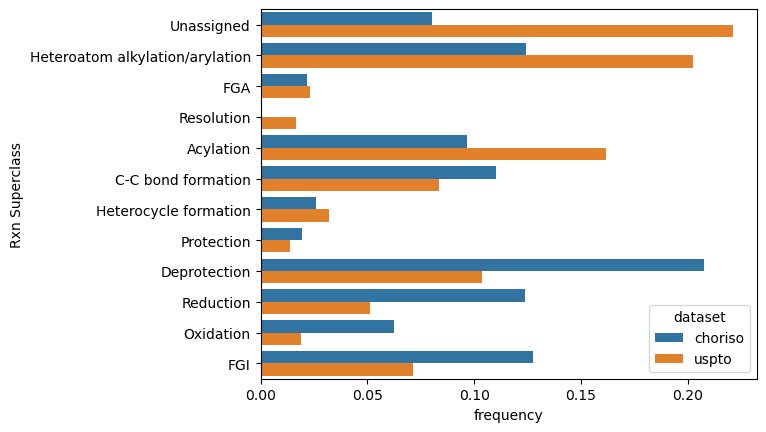

In [5]:
sns.barplot(data=merged, y="Rxn Superclass", x="one", hue="dataset", orient="h")
plt.xlabel("frequency")
plt.ylabel("Rxn Superclass")
plt.savefig("superclasses.svg", bbox_inches="tight")

## Product stereocenters

In [15]:
choriso_stereo = choriso["stereocenters"].value_counts()
choriso_stereo /= choriso_stereo.sum()
choriso_stereo = choriso_stereo.reset_index()
uspto_stereo = uspto["stereocenters"].value_counts()
uspto_stereo /= uspto_stereo.sum()
uspto_stereo = uspto_stereo.reset_index()

choriso_stereo["dataset"] = ["choriso"] * len(choriso_stereo)
uspto_stereo["dataset"] = ["uspto"] * len(uspto_stereo)

stereo_merged = pd.concat((choriso_stereo, uspto_stereo), axis=0)
stereo_merged["index"] = stereo_merged["index"].astype(int)

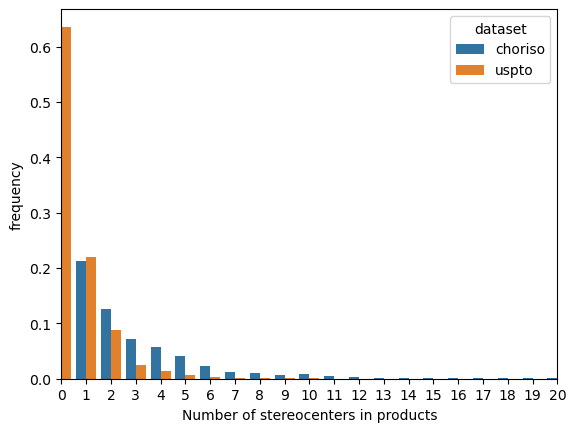

In [16]:
sns.barplot(data=stereo_merged, x="index", y="stereocenters", hue="dataset")
plt.xlim(0, 20)
plt.xlabel("Number of stereocenters in products")
plt.ylabel("frequency")
plt.savefig("stereocenters.svg", bbox_inches="tight");

## Product molar weight

In [17]:
choriso["dataset"] = ["choriso"] * len(choriso)
uspto["dataset"] = ["uspto"] * len(uspto)

prop_merge = pd.concat((choriso, uspto), axis=0)

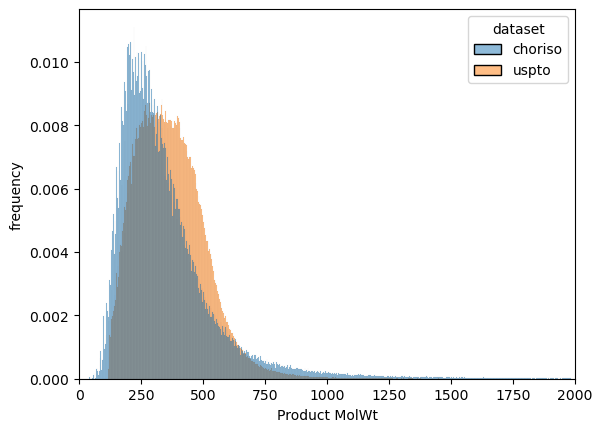

In [18]:
sns.histplot(
    data=prop_merge, x="MolWt", hue="dataset", kde=False, stat="proportion", common_norm=False
)
plt.xlim(0, 2000)
plt.ylabel("frequency")
plt.xlabel("Product MolWt")
plt.savefig("molwt.svg", bbox_inches="tight");